# Capstone IV

Create a movie or TV show recommendation system utilizing Netflix data.

Data set from Kaggle:
https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data

This data set has 4 different parts, and the first part contains 24 million data points. Since the machine was taking a long time to load all 4 sets, so I only used the first set for speed.

In [2]:
import pandas as pd
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Reshape, Concatenate, Dense
from keras.models import Model
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Import the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Load data from Google Drive
df_raw = pd.read_csv("/content/drive/MyDrive/python_for_data_scientists/example_data/combined_data_1.txt", header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
# Load data from local drive
# df_raw = pd.read_csv("C:\misc\CS\python_for_data_scientists\example_data\combined_data_1.txt", header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(df_raw.head(5))

      User  Rating        Date
0       1:     NaN         NaN
1  1488844     3.0  2005-09-06
2   822109     5.0  2005-05-13
3   885013     4.0  2005-10-19
4    30878     4.0  2005-12-26


In [5]:
df_raw['Rating'].isna().sum()

4499

There are 4499 missing rating rows

In [6]:
# Remove empty rating rows
temp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in temp_movies.values]

In [7]:
#print(movie_indices)

In [8]:
# Shift the movie indices by one to get the start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)
print(shifted_movie_indices)

deque([[548, 2], [694, 3], [2707, 4], [2850, 5], [3991, 6], [5011, 7], [5105, 8], [20016, 9], [20112, 10], [20362, 11], [20561, 12], [21108, 13], [21234, 14], [21353, 15], [21644, 16], [24344, 17], [31453, 18], [42176, 19], [42716, 20], [42833, 21], [43052, 22], [43256, 23], [43872, 24], [45206, 25], [46414, 26], [52276, 27], [52550, 28], [92303, 29], [92827, 30], [211241, 31], [211463, 32], [213318, 33], [220209, 34], [220318, 35], [221158, 36], [222098, 37], [222380, 38], [223183, 39], [223936, 40], [224428, 41], [224522, 42], [224651, 43], [224757, 44], [233259, 45], [235879, 46], [242438, 47], [244789, 48], [248381, 49], [248613, 50], [248942, 51], [249033, 52], [254181, 53], [254296, 54], [254456, 55], [256863, 56], [258697, 57], [262260, 58], [279666, 59], [279871, 60], [280167, 61], [280315, 62], [280606, 63], [280791, 64], [280887, 65], [281146, 66], [281313, 67], [281603, 68], [283820, 69], [283937, 70], [284281, 71], [285843, 72], [286023, 73], [286771, 74], [287160, 75], [28

In [9]:
# Combine the movie and rating dataframes
user_data = []

# Iterate over all movies
for [df_id1, movie_id], [df_id2, next_movie_id] in zip(movie_indices, shifted_movie_indices):

    # Check if last movie
    if df_id1 < df_id2:
        temp_df = df_raw.loc[df_id1 + 1 : df_id2 - 1].copy()
    else:
        temp_df = df_raw.loc[df_id1 + 1 :].copy()

    # Create movie_id column
    temp_df['Movie'] = movie_id

    # Append dataframe to list
    user_data.append(temp_df)
#print(user_data)

In [10]:
# Combine all dataframes
df = pd.concat(user_data)

In [11]:
print(df.shape)
df.head(5)

(24053764, 4)


,User,Rating,Date,Movie
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [12]:
# Load data for all movies
# The raw data has some rows with errors.
def handle_bad_lines(line):
    fields = [str(field) for field in line]
    movie_id = int(fields[0])
    release_year = int(fields[1])
    combined_title = ''.join(fields[2:]).strip()
    return movie_id, release_year, combined_title

movie_titles = pd.read_csv('/content/drive/MyDrive/python_for_data_scientists/example_data/movie_titles.csv',
                           encoding = 'ISO-8859-1',
                           engine = 'python',
                           on_bad_lines = handle_bad_lines,
                           header = None,
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print(movie_titles.shape)
print(movie_titles.head())

(17770, 2)
      Year                          Name
Id                                      
1   2003.0               Dinosaur Planet
2   2004.0    Isle of Man TT 2004 Review
3   1997.0                     Character
4   1994.0  Paula Abdul's Get Up & Dance
5   2004.0      The Rise and Fall of ECW


# Explore the data

What is the distribution of ratings?

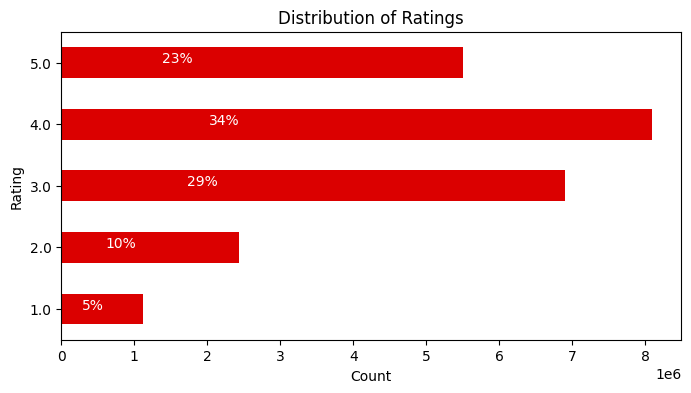

In [13]:
p = df.groupby('Rating')['Rating'].agg(['count'])

ax = p.plot(kind = 'barh', legend = False, figsize = (8,4), color='#db0000')
plt.title('Distribution of Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, '{:.0f}%'.format(p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white')

When were the movies released?

Text(0, 0.5, 'Number of Movies')

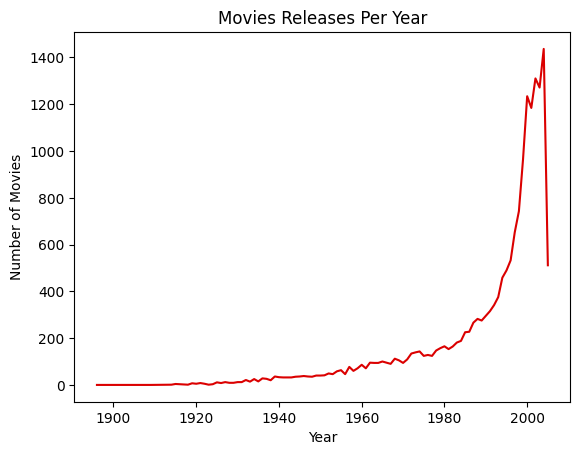

In [14]:
data = movie_titles['Year'].value_counts().sort_index()

plt.plot(data.index, data.values, color = '#db0000')
plt.title('Movies Releases Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')


There is a sharp drop of movie releases at the end. There is where the data provided stops.

# Further data processing
To reduce the effect of movies and users with few ratings, remove these from the model. Set minimum movie ratings to 8000 and minimum user ratings to 200

In [15]:
# Minimum movie ratings to 8000
min_movies_df = (df['Movie'].value_counts() > 8000)
min_movies = min_movies_df[min_movies_df].index.tolist()

# Minimum user ratings to 200
min_users_df = (df['User'].value_counts()> 200)
min_users = min_users_df[min_users_df].index.tolist()


In [16]:
# Select rows that have min movie and user requirements
df_min = df[(df['Movie'].isin(min_movies)) & (df['User'].isin(min_users))]
print(df_min.shape)

(4478403, 4)


This reduced the data points from 24 million to 4.47 million.

In [17]:
# Remove date column
df_min = df_min.drop('Date', axis=1).reset_index(drop=True)
print(df_min)

            User  Rating  Movie
0        1744889     1.0      8
1        1205593     4.0      8
2        1488844     4.0      8
3         306466     4.0      8
4        1331154     4.0      8
...          ...     ...    ...
4478398  2082452     3.0   4496
4478399   945992     3.0   4496
4478400    15737     4.0   4496
4478401   823628     5.0   4496
4478402  1055714     5.0   4496

[4478403 rows x 3 columns]


In [18]:
# Convert Movie to string
df_min['Movie'] = df_min['Movie'].astype(str)

In [21]:
# Split data into X and y for model
X = df_min.drop('Rating', axis=1)
y = df_min['Rating']

In [22]:
# Convert y to dataframe for tensorflow
y = pd.DataFrame(y)

In [23]:
# Create user and movie-id mapping to reset user and movie index for model
user_id_mapping = {id:i for i, id in enumerate(df_min['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_min['Movie'].unique())}

In [24]:
# Reindex users and movies (optional)
X['User'] = X['User'].map(user_id_mapping)
X['Movie'] = X['Movie'].map(movie_id_mapping)
X['User'] = X['User'].astype(str)
X['Movie'] = X['Movie'].astype(str)

# Split data into train and test sets

In [25]:
# Split 20% of data to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

# Ensure data types are float
train_user_data = X_train['User'].astype(float)
train_movie_data = X_train['Movie'].astype(float)
test_user_data = X_test['User'].astype(float)
test_movie_data = X_test['Movie'].astype(float)

In [26]:
# Identify unique user ids and movie titles in the data
unique_movie_titles = df_min['Movie'].unique()
unique_user_ids = df_min['User'].unique()

# Calculate the number of unique users and movies
users = len(unique_user_ids)
movies = len(unique_movie_titles)

# Model

## Deep learning artificial neural network Model #1.

*   2 layers: 256 and 1 (output) neurons
*   ADAM optimizer



In [27]:
# Input variables
user_embedding_size = 20
movie_embedding_size = 10

# Define input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Convert user and movie strings into float vectors. Similar to one hot encoding.
user_embedding = Embedding(output_dim = user_embedding_size,
                           input_dim = users,
                           input_length=  1,
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim = movie_embedding_size,
                            input_dim = movies,
                            input_length = 1,
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers to input into first ANN layer
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers for the model
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')
model.summary()

# Fit model
model.fit([train_user_data, train_movie_data],
          y_train['Rating'],
          batch_size=256,
          epochs=1,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = y_test['Rating'].values

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 20)          │        416,560 │ user[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 10)          │          5,780 │ movie[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 20)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 10)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 30)             │              0 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │          7,936 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 430,533 (1.64 MB)

 Trainable params: 430,533 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

12596/12596 ━━━━━━━━━━━━━━━━━━━━ 96s 8ms/step - loss: 1.0829 - val_loss: 0.8236
27991/27991 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step


Root mean square error (RMSE) is a good metric for the ratings model. The ratings are numeric values, and the RMSE is compared from the model predictions to the true test rating values. The loss displayed in the model is mean squared error.

In [28]:
# Compute RMSE
rmse = mean_squared_error(y_pred=y_pred, y_true=y_true)**(1/2)
print('RSME with model #1: {:.4f}'.format(rmse))

RSME with model #1: 0.9075


## Deep learning artificial neural network Model #2.

*   3 layers: 256, 128, 1 (output) neurons
*   SGD optimizer



In [29]:
# Define input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Convert user and movie strings into float vectors. Similar to one hot encoding.
user_embedding = Embedding(output_dim = user_embedding_size,
                           input_dim = users,
                           input_length=  1,
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim = movie_embedding_size,
                            input_dim = movies,
                            input_length = 1,
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers to input into first ANN layer
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers for the model
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense1 = Dense(256)(concat)
dense2 = Dense(128)(dense1)
y = Dense(1)(dense2)

# Setup model
model2 = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model2.compile(loss='mse', optimizer='sgd')
model2.summary()

# Fit model
model2.fit([train_user_data, train_movie_data],
          y_train['Rating'],
          batch_size=256,
          epochs=1,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model2.predict([test_user_data, test_movie_data])
y_true = y_test['Rating'].values

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 20)          │        416,560 │ user[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 10)          │          5,780 │ movie[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 20)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 10)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 30)             │              0 │ reshape_2[0][0],       │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │          7,936 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            129 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 463,301 (1.77 MB)

 Trainable params: 463,301 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

12596/12596 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 1.0851 - val_loss: 0.9720
27991/27991 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step


In [30]:
# Compute RMSE
rmse = mean_squared_error(y_pred=y_pred, y_true=y_true)**(1/2)
print('RMSE with model #2: {:.4f}'.format(rmse))

RSME with model #2: 0.9861


The first model had a lower root mean squared error, so this will be used to predict a user's ratings.



# Predict movie ratings for a user.

In [50]:
# Predict ratings for user "2"
# Create series with all movies
test_movies_map = pd.Series(df_min['Movie'].unique(), name='Movie').map(movie_id_mapping)

# Create series with user id "2"
test_user_map = pd.Series([2 for i in range(1,df_min['Movie'].unique().shape[0]+1)], name='User')

# Use the model to predict user ratings
test_user_predictions = model.predict([test_user_map, test_movies_map])

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [52]:
# Create a dataframe to combine predictions with movie name
results = pd.DataFrame()
results['Movie'] = df_min['Movie'].unique().astype(int)

# Add predicted rating data to each movie
results['Predicted_rating'] = test_user_predictions

# Map movie ID to movie title
output = results.merge(movie_titles, left_on='Movie', right_on='Id')

# Remove excess columns
output.drop('Movie', axis=1, inplace=True)
output.drop('Year', axis=1, inplace=True)

# Show Movie in first column
output = output[['Name', 'Predicted_rating']]
output = output.rename(columns={'Name': 'Movie or Show Title', 'Predicted_rating': 'Predicted Rating'})

# Sort by rating
output = output.sort_values(by=['Predicted Rating'], ascending = False)
print(output.head(10))

                               Movie or Show Title  Predicted Rating
260                         The Simpsons: Season 6          4.551415
276                         The Simpsons: Season 3          4.386820
312  Lord of the Rings: The Fellowship of the Ring          4.373515
176                       Six Feet Under: Season 4          4.369019
422                          The Godfather Part II          4.347314
518                      Finding Nemo (Widescreen)          4.346714
383              The Simpsons: Treehouse of Horror          4.340303
551                                The Sixth Sense          4.305430
155                    The Best of Friends: Vol. 4          4.293063
132                         The Simpsons: Season 1          4.279273
